<a href="https://colab.research.google.com/github/lovekittynine/Annotated-DDPM/blob/master/ClipGuidanceDDPM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CLIP引导的DDPM模型实现可控图像生成

In [1]:
!pip3 install -U diffusers accelerate transformers open-clip-torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.2/251.2 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 39.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 58.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 68.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 73.1 MB/s eta 0:00:00


In [3]:
import numpy as np
from diffusers import DDPMPipeline, DDIMScheduler
import open_clip
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 加载clip model
clip_model, _, preprocess = open_clip.create_model_and_transforms("ViT-B-32-quickgelu", pretrained="openai")
clip_model.to(device)

# 加载DDPM model
pipeline = DDPMPipeline.from_pretrained("google/ddpm-celebahq-256")
pipeline.to(device)

# scheduler
noise_scheduler = DDIMScheduler.from_config(pipeline.scheduler.config)

print(preprocess)



100%|███████████████████████████████████████| 354M/354M [00:05<00:00, 65.4MiB/s]


diffusion_pytorch_model.safetensors not found


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=warn)
    CenterCrop(size=(224, 224))
    <function _convert_to_rgb at 0x7c15d81a95a0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)


In [19]:
from torchvision import transforms
import torchvision

# transforms针对非PIL对象也可以使用[tensor]
tfms = transforms.Compose([transforms.CenterCrop(224),
                           transforms.RandomAffine(5),
                           transforms.RandomHorizontalFlip(),
                           transforms.Normalize([0.48145466, 0.4578275, 0.40821073], [0.26862954, 0.26130258, 0.27577711])
                           ])


def clip_loss(image, text_features):
    """
    clip 引导图文对比损失
    """
    image_features = clip_model.encode_image(tfms(image))
    # 4x1x512
    image_features = F.normalize(image_features.unsqueeze(1), dim=2)
    # 1x1x512
    text_features = F.normalize(text_features.unsqueeze(0), dim=2)
    dists = (image_features.sub(text_features).norm(dim=2).div(2).arcsin().pow(2).mul(2))
    return dists.mean()




In [20]:
prompt = "a beautiful HD women face"
guidance_scale = 12
n_cuts = 8

text = open_clip.tokenize([prompt]).to(device)
print(text.shape)
with torch.inference_mode():
    text_features = clip_model.encode_text(text)
    print(f"text feature shape: {text_features.shape}")

torch.Size([1, 77])
text feature shape: torch.Size([1, 512])


torch.Size([4, 3, 256, 256]) torch.float32
step: 0 guidance_loss: 11.052322387695312
torch.Size([4, 3, 256, 256]) torch.float32
step: 5 guidance_loss: 10.538402557373047
torch.Size([4, 3, 256, 256]) torch.float32
step: 10 guidance_loss: 10.417469024658203
torch.Size([4, 3, 256, 256]) torch.float32
step: 15 guidance_loss: 10.2801513671875
torch.Size([4, 3, 256, 256]) torch.float32
step: 20 guidance_loss: 10.324159622192383
torch.Size([4, 3, 256, 256]) torch.float32
step: 25 guidance_loss: 10.400175094604492
torch.Size([4, 3, 256, 256]) torch.float32
step: 30 guidance_loss: 10.275876998901367
torch.Size([4, 3, 256, 256]) torch.float32
step: 35 guidance_loss: 10.33826732635498
torch.Size([4, 3, 256, 256]) torch.float32
step: 40 guidance_loss: 10.244396209716797
torch.Size([4, 3, 256, 256]) torch.float32
step: 45 guidance_loss: 10.186408996582031


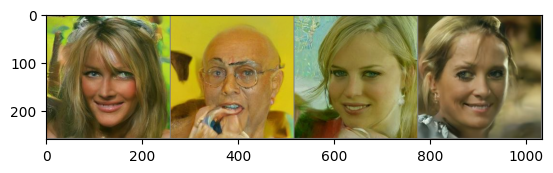

In [27]:
# 噪声输入
x = torch.randn((4, 3, 256, 256)).to(device)
noise_scheduler.set_timesteps(num_inference_steps=50)

# 推理阶段
for i, t in enumerate(noise_scheduler.timesteps):
    model_input = noise_scheduler.scale_model_input(x, t)

    with torch.no_grad():
        noise_pred = pipeline.unet(model_input, t).sample

    cond_grad = 0

    for cut in range(n_cuts):
        x = x.detach().requires_grad_()
        # 获取去燥后的原始图像x0
        x0 = noise_scheduler.step(noise_pred, t, x).pred_original_sample
        # 计算对比损失
        loss = clip_loss(x0, text_features) * guidance_scale

        cond_grad -= torch.autograd.grad(loss, x)[0] / n_cuts

    if i%5 == 0:
        print(x0.shape, x0.dtype)
        print(f"step: {i} guidance_loss: {loss.item()}")

    # 沿着guidance 方向更新 x
    # 尝试在前面时间步添加少量指引, 在后面时间步添加更多指引, 效果最好
    alpha_bar = noise_scheduler.alphas_cumprod[i*20]
    x = x + cond_grad * (1.0 - alpha_bar).sqrt()

    # 得到前一步去噪结果
    x = noise_scheduler.step(noise_pred, t, x).prev_sample


grid = torchvision.utils.make_grid(x.detach().cpu(), nrow=4)
grid = grid.permute([1,2,0]).clip(-1, 1) * 0.5 + 0.5
plt.imshow(grid)
plt.show()


